# 二维码的检测与识别
**王佳栋**

**2018年11月19日**

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import morphology
import sklearn
from PIL import Image
from PIL import ImageDraw
from pylab import *
import math
import cv2 as cv

In [3]:
def show_fromarray(pix):
    im_temp = Image.fromarray(pix)
    imshow(im_temp)
    return


None (1080, 1442) L


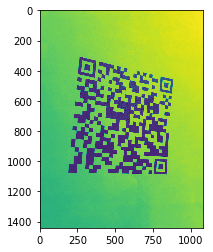

In [79]:
original = Image.open('Photo2.jpg').convert("L")
imshow(original)
print(original.format, original.size, original.mode)

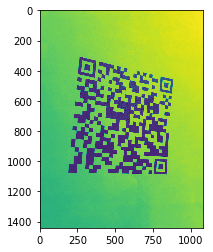

(1442, 1080)


In [80]:
box = (50,550,750,1200)
#pic = original.crop(box)
pic = original
imshow(pic)
show()
pix = np.array(pic.getdata()).reshape(pic.size[1], pic.size[0])
print(pix.shape)


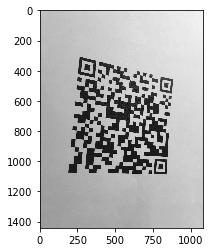

In [81]:
pic = Image.fromarray(pix)
imshow(pic)

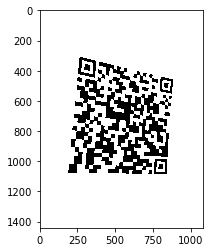

In [82]:
# Step1: 转化成二值图像
threshold = np.average(pix) -40
pix_wb = (pix >= threshold).astype('int')*255

# 将所有的黑色点放到一个ndarray中
n_QRCode = np.count_nonzero(~(pix >= threshold))
points_QRCode = np.zeros([n_QRCode,2])
m=0
for i in range(pix_wb.shape[0]):
    for j in range(pix_wb.shape[1]):
        if pix_wb[i,j]<=threshold:
            points_QRCode[m] = [i,j]
            m=m+1

# show
show_fromarray(pix_wb)

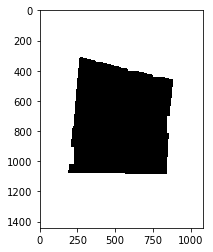

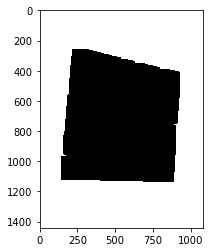

In [83]:
# Step2: 开运算
n = 100
selem_user = np.ones([n,n])
pix_opening = morphology.opening(pix_wb,selem = selem_user)
# show
show_fromarray(pix_opening)
show()


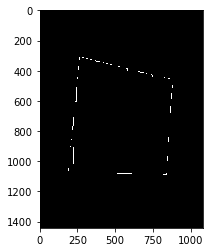

In [84]:
# Step3: 识别边界
selem_cube = np.ones([3,3])
pix_gradient = morphology.dilation(pix_opening,selem=selem_cube) - morphology.erosion(pix_opening,selem=selem_cube)
# show
show_fromarray(pix_gradient)

There are 6020 points on the border. 
the 0 -th line have 1338 points on the line
the 1 -th line have 1304 points on the line
the 2 -th line have 1191 points on the line
the 3 -th line have 897 points on the line
[0.33333333333333331, 0.0021008403361344537, 0.017857142857142856, -0.0028089887640449437] [-0.0080000000000000002, 0.021739130434782608, -0.0044247787610619468, -0.038461538461538464] [-356.28800000000001, -6.3573255389112164, -4.3435524652338806, 35.106093344857392]


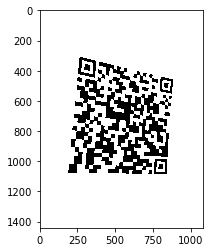

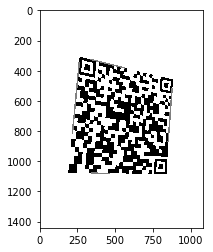

In [85]:
# 将边界点放入一个ndarray
n_onborder = np.count_nonzero(pix_gradient)
print('There are %d points on the border. ' %n_onborder)
points_onborder = np.zeros([n_onborder,2])
m = 0
for i in range(pix_gradient.shape[0]):
    for j in range(pix_gradient.shape[1]):
        if pix_gradient[i,j]:
            points_onborder[m] = [i,j]
            m = m+1

# RANSAC
n_ite = 100
threshold = 3
A = [0,0,0,0]
B = [0,0,0,0]
C = [0,0,0,0]
X1 = [0,0,0,0]
Y1 = [0,0,0,0]
X2 = [0,0,0,0]
Y2 = [0,0,0,0]
Points_online = np.zeros([4,points_onborder.shape[0]], dtype='bool')
for k in [0,1,2,3]:
    n_online_max = 0
    for i in range(n_ite):
        rand_couple = np.random.randint(0,n_onborder,2)
        if rand_couple[0]!=rand_couple[1]:
            # ax+by+c=0
            (x1,y1) = (points_onborder[rand_couple[0]][0],points_onborder[rand_couple[0]][1])
            (x2,y2) = (points_onborder[rand_couple[1]][0],points_onborder[rand_couple[1]][1])
            a = 0.0 if (x2 == x1) else 1.0/(x2-x1)
            b = 0.0 if (y2 == y1) else -1.0/(y2-y1)
            c = -1.0*x1*a-1.0*y1*b
            dist = np.abs((np.dot(points_onborder,np.array([a,b]).T)+c))/np.sqrt(a**2+b**2)
            on_line = (dist <= threshold) & ~ Points_online[0,:]& ~ Points_online[1,:]& ~ Points_online[2,:]& ~ Points_online[3,:]
            n_online = np.count_nonzero(on_line)
            if n_online>n_online_max:
                Points_online_temp = np.copy(on_line)
                (A[k],B[k],C[k]) = (a,b,c)
                (X1[k],Y1[k],X2[k],Y2[k]) = (x1,y1,x2,y2)
                n_online_max = n_online
    print('the %d -th line have %d points on the line' %(k,n_online_max))
    Points_online[k] = Points_online_temp
print(A,B,C)

im = Image.fromarray(pix_wb)
show_fromarray(pix_wb)
show()

draw = ImageDraw.Draw(im)
for i in range(4):
    draw.line([Y1[i],X1[i],Y2[i],X2[i]],fill=128, width =10)
del draw
imshow(im)


[[ 1073.39293739   188.70572454]
 [ 1088.86163578   833.23482435]
 [  308.31825114   262.64151354]
 [  461.06533841   879.08511573]]


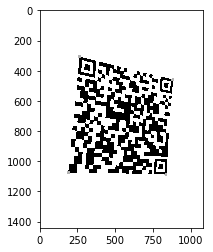

In [86]:
# 找到四个顶点
def find_intersection(a1,b1,c1,a2,b2,c2):
    return (b1*c2-b2*c1)/(a1*b2-a2*b1), (c1*a2-c2*a1)/(a1*b2-a2*b1)

corners = np.zeros([4,2])
k = 0
for i in range(3):
    for j in range(i+1,4):
        a1 = A[i]
        b1 = B[i]
        a2 = A[j]
        b2 = B[j]
        if (np.abs((a1*a2+b1*b2)/((a1**2+b1**2)*(a2**2+b2**2))**0.5)< np.cos(np.pi*1/3) and k<4):
            corners[k][0], corners[k][1]= find_intersection(A[i],B[i],C[i],A[j],B[j],C[j])
            k+=1
print(corners)

im = Image.fromarray(pix_wb)
draw = ImageDraw.Draw(im)
for i in range(4):
    draw.ellipse([ corners[i,1]-10,corners[i,0]-10,  corners[i,1]+10,corners[i,0]+10 ],fill=180)
del draw
imshow(im)

In [87]:
# 将四个顶点以最右边的顶点为基准按顺时针排列
print(corners)
for i in range(1,4):
    if corners[i][0]>corners[0][0]:
            temp = np.copy(corners[i])
            corners[i] = np.copy(corners[0])
            corners[0] = temp        
print(corners)
angles =[0]
for k in range(1,4):
    if (corners[k][0]-corners[0][0])!=0:
        angles.append(math.atan((corners[k][1]-corners[0][1])/(corners[k][0]-corners[0][0]))+np.pi if (corners[k][0]-corners[0][0])< 0 \
                                else -math.atan((corners[k][1]-corners[0][1])/(corners[k][0]-corners[0][0])) if (corners[k][1]-corners[0][1])< 0 \
                                else -math.atan((corners[k][1]-corners[0][1])/(corners[k][0]-corners[0][0]))+np.pi*2)
    else:
        angles.append(-np.pi/2 if (corners[k][1]-corners[0][1])<0 else -np.pi*1.5)
print(angles)

for i in range(1,3):
    for j in range(i,4):
        if angles[j]>angles[i]:
            temp = angles[i]
            angles[i] = angles[j]
            angles[j] = temp
            temp = np.copy(corners[i])
            corners[i] = np.copy(corners[j])
            corners[j] = temp
print(corners)


[[ 1073.39293739   188.70572454]
 [ 1088.86163578   833.23482435]
 [  308.31825114   262.64151354]
 [  461.06533841   879.08511573]]
[[ 1088.86163578   833.23482435]
 [ 1073.39293739   188.70572454]
 [  308.31825114   262.64151354]
 [  461.06533841   879.08511573]]
[0, 4.68839358679282, 3.772835898684278, 3.0686883837744494]
[[ 1088.86163578   833.23482435]
 [ 1073.39293739   188.70572454]
 [  308.31825114   262.64151354]
 [  461.06533841   879.08511573]]


Before optimization: 
 [[ 1088.86163578   833.23482435]
 [ 1073.39293739   188.70572454]
 [  308.31825114   262.64151354]
 [  461.06533841   879.08511573]]
After optimization: 
 [[ 1092.86163578   838.23482435]
 [ 1075.39293739   185.20572454]
 [  306.31825114   259.64151354]
 [  458.56533841   882.58511573]]


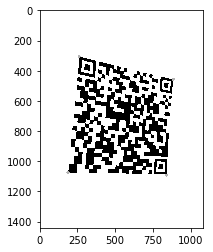

In [88]:
#优化顶点位置
def on_one_side(P1,P2, points):
    n_p = points.shape[0]
    (x1,y1,x2,y2)=(P1[0],P1[1],P2[0],P2[1])
    a = 0.0 if (x2 == x1) else 1.0/(x2-x1)
    b = 0.0 if (y2 == y1) else -1.0/(y2-y1)
    c = -1.0*x1*a-1.0*y1*b
    side = (np.dot(points,np.array([a,b]).T)+c) >0
    return np.abs(np.count_nonzero(side)*2-n_p)

def f_obj(corners, points):
    return on_one_side(corners[0],corners[1],points)+on_one_side(corners[1],corners[2],points)+on_one_side(corners[2],corners[3],points)+on_one_side(corners[3],corners[0],points)

# 微小改变定点位置使得对于任意一边，有更多的点在四边形的同侧
print('Before optimization: \n',corners)

n_ite = 50
for i in range(n_ite):
    for j in range(4):
        change = np.random.randint(-1,2,[1,2])/2.
        corners_changed = np.copy(corners)
        corners_changed[j] = corners_changed[j]+change
        #print(corners_changed)
        #print(f_obj(corners_changed, points_QRCode),  f_obj(corners, points_QRCode))
        if f_obj(corners_changed, points_QRCode) > f_obj(corners, points_QRCode):
            corners = np.copy(corners_changed)

print('After optimization: \n',corners)

# Show new corners
im = Image.fromarray(pix_wb)
draw = ImageDraw.Draw(im)
for i in range(4):
    draw.ellipse([ corners[i,1]-10,corners[i,0]-10,  corners[i,1]+10,corners[i,0]+10 ],fill=180)
del draw
imshow(im)

In [89]:
# 求单应性矩阵
d = 1
L = np.zeros([8,9])
X_world = np.array([[d,0],[0,0],[0,d],[d,d]])
for i in range(4):
    L[i*2,0:3] = np.array([X_world[i,0],X_world[i,1],1])
    L[i*2,6:9] = np.array([X_world[i,0],X_world[i,1],1])*(-corners[i,0])
    L[i*2+1,3:6] = np.array([X_world[i,0],X_world[i,1],1]) 
    L[i*2+1,6:9] = np.array([X_world[i,0],X_world[i,1],1])*(-corners[i,1])
print(L)
hr = np.linalg.eigh(np.dot(L.T,L))[1][:,0]
H = np.reshape(hr,[3,3])
print(H)

[[  1.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00  -1.09286164e+03  -0.00000000e+00
   -1.09286164e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   1.00000000e+00  -8.38234824e+02  -0.00000000e+00
   -8.38234824e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   -1.07539294e+03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
   -1.85205725e+02]
 [  0.00000000e+00   1.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00  -0.00000000e+00  -3.06318251e+02
   -3.06318251e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.00000000e+00   1.00000000e+00  -0.00000000e+00  -2.59641514e+02
   -2.59641514e+02]
 [  1.00000000e+00   1.00000000e+00   1.

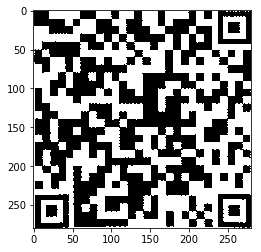

In [90]:
# 单应性变换
n_perpix = 10
n_pix = 28*n_perpix
pix_QRCode = np.zeros([n_pix, n_pix])
for i in range(n_pix):
    for j in range(n_pix):
        X_world = [float(i)*d/n_pix, float(j)*d/n_pix, 1]
        U = np.dot(H, X_world)/np.dot(H, X_world)[2]
        #print(U)
        pix_QRCode[i,j] = pix_wb[int(round(U[0])),int(round(U[1]))]
show_fromarray(pix_QRCode)

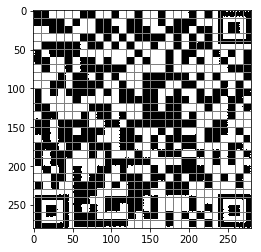

In [91]:
pix_test = np.copy(pix_QRCode)
im = Image.fromarray(pix_test)
draw = ImageDraw.Draw(im)
for i in range(28):
    draw.line([i*10+10,0,i*10+10,279],fill=128)
    draw.line([0,i*10+10,279,i*10+10],fill=128)
del draw
imshow(im)

[[   0.    0.    0. ...,  255.  255.  255.]
 [   0.    0.    0. ...,  255.  255.  255.]
 [   0.    0.    0. ...,  255.  255.  255.]
 ..., 
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]]
1130 2315 2015 2297


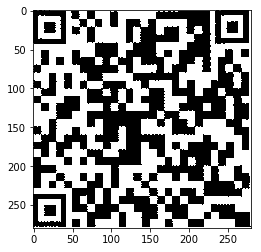

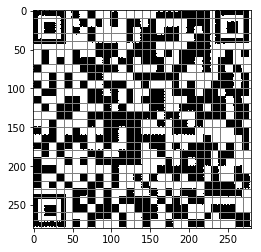

In [92]:
# 定义回字型特征
feature_77 = np.array([[0,0,0,0,0,0,1],
                      [0,1,1,1,1,0,1],
                      [0,1,0,0,1,0,1],
                      [0,1,0,0,1,0,1],
                      [0,1,1,1,1,0,1],
                      [0,0,0,0,0,0,1],
                      [1,1,1,1,1,1,1]])*255
feature_55 = np.zeros([5*n_perpix, 5*n_perpix])
for i in range(5*n_perpix):
    for j in range(5*n_perpix):
        feature_55[i,j]=feature_77[int(i*1.0/5/n_perpix*7),int(j*1.0/5/n_perpix*7)]
print(feature_55)

# 特征匹配并旋转
def matching(target, kernel):
#    result = 0
#    for i in range(4):
#        kernel = np.rot90(kernel)
#        result = result + np.count_nonzero(target == kernel)
    return np.count_nonzero(target == kernel)
tl=matching(pix_QRCode[0:5*n_perpix,0:5*n_perpix], feature_55)
lr=matching(pix_QRCode[-5*n_perpix:,-5*n_perpix:], np.rot90(np.rot90(feature_55)))
ll=matching(pix_QRCode[-5*n_perpix:,0:5*n_perpix], np.rot90(feature_55))
tr=matching(pix_QRCode[0:5*n_perpix,-5*n_perpix:], np.rot90(np.rot90(np.rot90(feature_55))))
print(tl,lr,ll,tr)
if tr<tl and tr<lr and tr<ll:
    pix_QRCode = np.rot90(np.rot90(np.rot90(pix_QRCode)))
if tl<tr and tl<ll and tl<lr:
    pix_QRCode = np.rot90(np.rot90(pix_QRCode))
if ll<lr and ll<tr and ll<tl:
    pix_QRCode = np.rot90(pix_QRCode)
show_fromarray(pix_QRCode)
show()

pix_test = np.copy(pix_QRCode)
im = Image.fromarray(pix_test)
draw = ImageDraw.Draw(im)
for i in range(28):
    draw.line([i*10+10,0,i*10+10,279],fill=128)
    draw.line([0,i*10+10,279,i*10+10],fill=128)
del draw
imshow(im)
show()

Elimination of a white border of width 0 on the right and a white  border of with 0 on the bottom. 


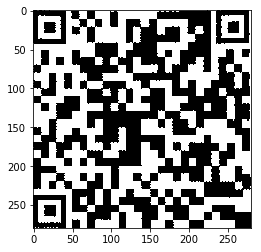

In [93]:
# 根据边角的回字图案优化边界
def projection(pix_source, shape_dest):
    dest = np.zeros(shape_dest)
    for i in range(shape_dest[0]):
        for j in range(shape_dest[1]):
            dest[i,j] = pix_source[int(round(i/shape_dest[0]*pix_source.shape[0])) ,int(round(j/shape_dest[1]*pix_source.shape[1])) ]
    return dest

disp_max = 5

# 优化右边界 Optimize Right Border
max_point = 0
for i in range(disp_max):
    match_point = matching(pix_QRCode[0:5*n_perpix,-5*n_perpix:], np.rot90(np.rot90(np.rot90(feature_55))))
    if match_point>max_point:
        disp_left = i
        max_point = match_point
# 优化下边界 Optimize Low Border
max_point = 0
for i in range(disp_max):
    match_point = matching(pix_QRCode[-5*n_perpix:,0:5*n_perpix], np.rot90(feature_55))
    if match_point>max_point:
        disp_up = i
        max_point = match_point        
        
print('Elimination of a white border of width %d on the right and a white  border of with %d on the bottom. ' %(disp_left, disp_up))
# Projection
pix_QRCode = projection(pix_QRCode[:-1-disp_left,:-1-disp_up], pix_QRCode.shape)

show_fromarray(pix_QRCode)
show()


[[2 2 2 2 2 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2 2 2]
 [2 2 2 2 2 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 2 2 2 2 2]
 [2 2 2 2 2 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 2 2 2 2 2]
 [2 2 2 2 2 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 2 2 2 2 2]
 [2 2 2 2 2 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 2 2 2 2 2]
 [1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0]
 [1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1]
 [0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1]
 [1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0]
 [0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0]
 [1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0]
 [0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1]
 [1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0]
 [1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0]
 [1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1]
 [0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 

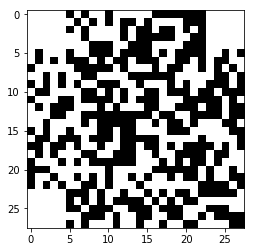

In [96]:
results = np.zeros([28,28])
for i in range(28):
    for j in range(28):
        cell = pix_QRCode[i*n_perpix:(i+1)*n_perpix,j*n_perpix:(j+1)*n_perpix]
        value = np.average(cell)
        results[i,j] = 1 if value>=128 else 0
results[0:5,0:5]= 2
results[-5:,0:5]= 2
results[0:5,-5:]= 2
results=results.astype('int')
print(results)

show_fromarray(results.astype('float')*255)

In [97]:
output = open('QRCode_Result.txt', 'w')
output.writelines(str(results))